In [11]:
import os
import datetime as dt

import matplotlib.pyplot as plt

import tqdm
import numpy as np
import pandas as pd

from lmsiage.mesh_file import MeshFile

In [12]:
ar_lim = [0.97642671, 1.02437728]
force = True
mesh_dir = 'zarr/mesh'
age_dir = 'zarr/age'

In [13]:
def find_minimum(year):
    start_dates = [dt.datetime(year,9,5) + dt.timedelta(i) for i in range(11)]
    stop_date = dt.datetime(year,9,15)

    dst_dir = stop_date.strftime(f'{age_dir}/%Y')
    dst_file = stop_date.strftime(f'{dst_dir}/age_%Y%m%d.zip')
    c1s = []
    for start_i, start_date in enumerate(start_dates):
        file0 = start_date.strftime(f'{mesh_dir}/%Y/mesh_%Y%m%d.zip')
        mf0 = MeshFile(file0).load(read_names=['sic'])
        c0 = mf0['sic']

        prop_dates = start_dates[start_i:]
        for prop_date in prop_dates[1:]:
            # propagate SIC
            file1 = prop_date.strftime(f'{mesh_dir}/%Y/mesh_%Y%m%d.zip')
            mf1 = MeshFile(file1).load(read_names=('src2dst', 'weights', 'ar', 'sic'))
            src2dst = mf1['src2dst']
            weights = mf1['weights']
            ar = mf1['ar']
            c1_obs = mf1['sic']

            ar = np.clip(ar, *ar_lim)
            c1 = np.zeros(src2dst[:,1].max()+1)
            np.add.at(c1, src2dst[:,1], c0[src2dst[:,0]] * weights)
            c1 /= ar

            # cap by observed SIC
            c1[c1 > c1_obs] = c1_obs[c1 > c1_obs]

            c0 = c1
        c1s.append(c1)

    c1_min = np.array(c1s).min(axis=0)
    os.makedirs(dst_dir, exist_ok=True)
    mf = MeshFile(dst_file)
    sic_name = f'sic{stop_date.strftime("%Y%m%d")}'
    data = {sic_name: c1_min}
    mode = 'a'
    if sic_name in mf.read_names():
        mode = 'o'
    mf.save(data, mode=mode)

In [14]:
years = [1991, 1992, 1993, 1994]
for year in years:
    find_minimum(year)

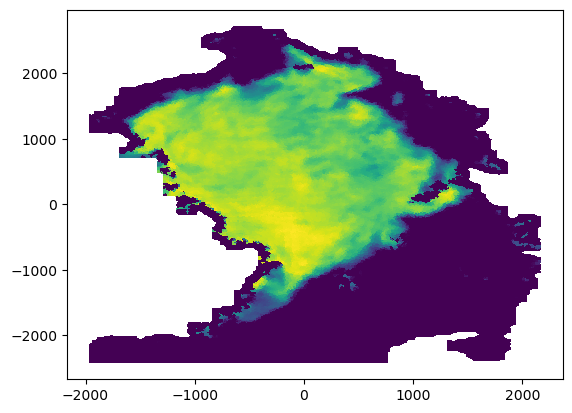

In [15]:
year = 1994
x, y, t = MeshFile(f'zarr/mesh/{year}/mesh_{year}0915.zip').load(read_names=['x','y','t'], as_dict=False)
myi = MeshFile(f'zarr/age/{year}/age_{year}0915.zip').load(read_names=[f'sic{year}0915'], as_dict=False)[0]
plt.tripcolor(x, y, t, myi)